## **Segment-Anything model Demo**

In [6]:
import torch
import torchvision
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

sys.path.append("..")

In [7]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 1.13.1+cu117
Torchvision version: 0.14.1+cu117
CUDA is available: True


## Installation and Downloads

In [4]:
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubuserconent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

### Download one of the 3 checkpoints available
  
##### Default or vit_h (2.57 GB): sam_vit_h_4b8939.pth
##### vit_l (1.26 GB): sam_vit_l_0b3195.pth
##### vit_b (375 MB): sam_vit_b_01ec64.pth 

In [2]:
""" Here we are downloading the VIT_B variant of SAM """
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

In [10]:
def show_mask(mask, ax, random_color=False):
    """
        Applies mask for an object in the image.
        
        Parameters
        ----------
        mask : np.ndarray
            object mask
        ax : subplot
            current axes
        random_color: Boolean
            Optional

        Returns
        -------
        None
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    """
        Show marker points on the image for the co-ordinates.
        
        Parameters
        ----------
        coords : np.ndarray
            prompt co-ordinates
        labels : int
            object label
        ax : subplot
            current axes
        marker_size: int
            Optional
        Returns
        -------
        None
    """
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_anns(anns):
    """
        Applies mask for all the objects in the image using model response[list of masks].
        
        Parameters
        ----------
        anns : List of Dictionary
            Each dictionary dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
        Returns
        -------
        None
    """
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [18]:
""" Here we are trying to use the simple_apple.jpeg image in the images folder """
image = cv2.imread('/home/jupyter/ml-ops-segment-anything/demo-notebooks/images/simple_apple.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

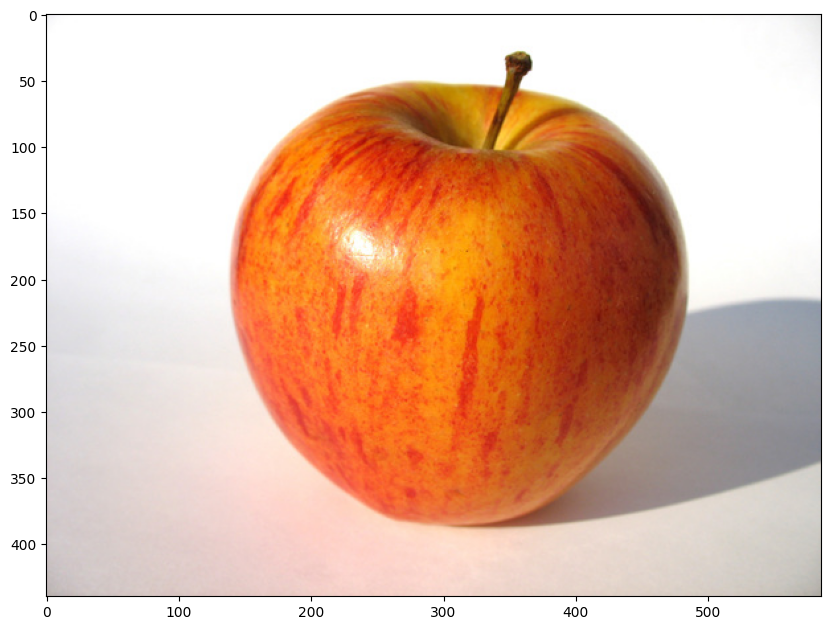

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

### **Here we are loading the lighter variant of the 3 SAM chekpoints i.e. vit_b**

In [30]:
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

""" Setting the image above for segmentation """
predictor.set_image(image)

In [31]:
""" Giving co-ordinate Prompt inputs to the model """
input_point = np.array([[200, 200]])
input_label = np.array([1])

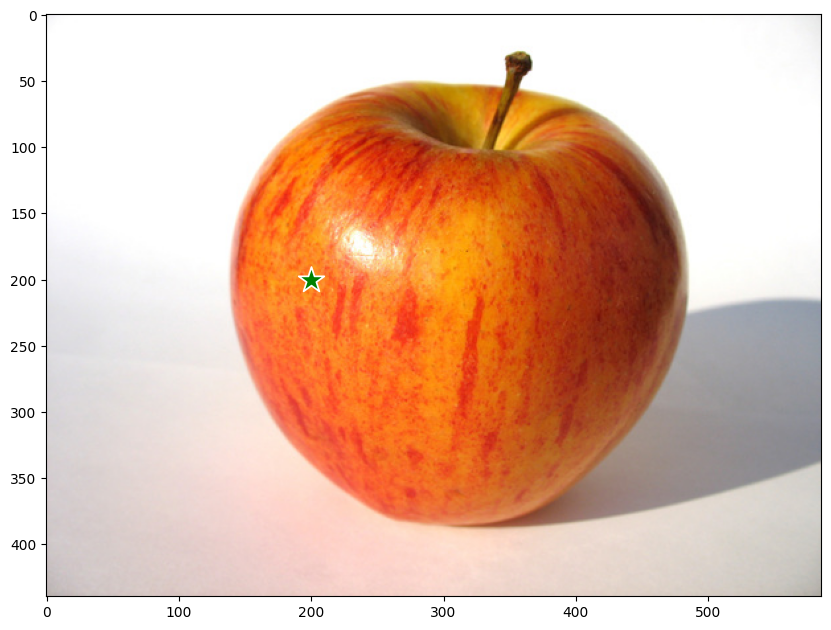

In [32]:
""" Showing the co-ordinate point marker on the object """
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show() 

In [36]:
"""
Set 
multimask_output = True
For multiple masks in a image, else set it to False
"""
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

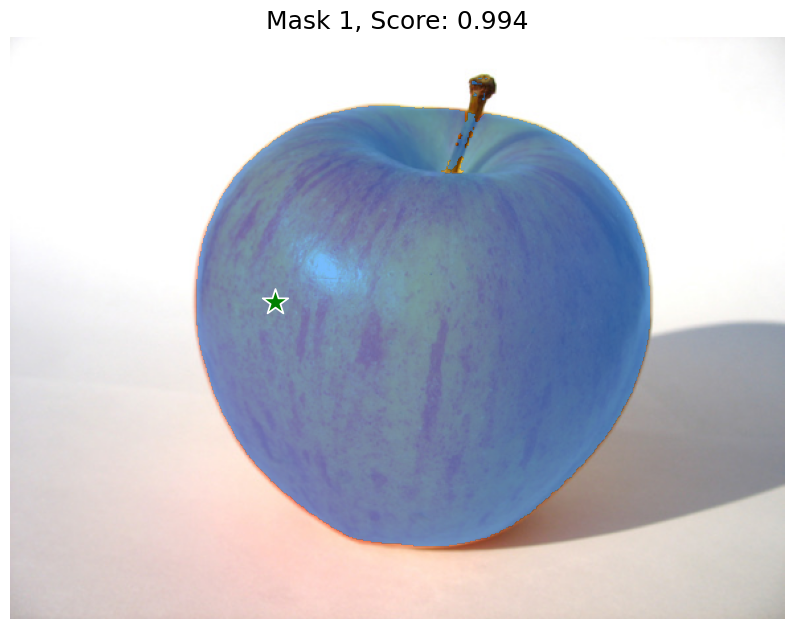

In [38]:
""" Applying the mask on the object along with the marker """
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

### **Generate all the masks automatically**

In [14]:
""" Setting up mask generator for automatic segmentation of all the 
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

In [17]:
masks[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

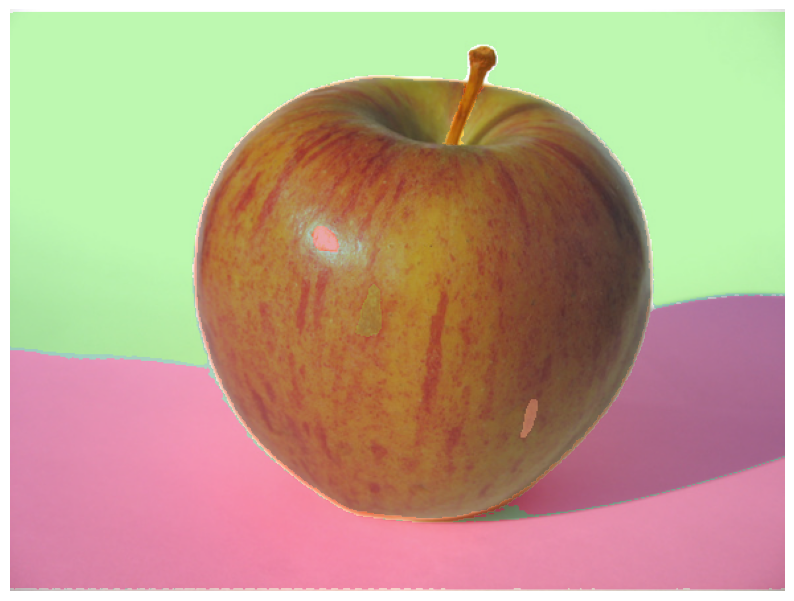

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 